In [27]:
import torch
import matplotlib.pyplot
import torchvision
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torchvision.transforms as T
from torch.utils.data import sampler

In [7]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
dtype = torch.float32

device

device(type='cpu')

In [94]:
transform = T.Compose([
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])

inv_transform = T.Compose([
                T.Normalize((0., 0., 0.), (1/0.2023, 1/0.1994, 1/0.2010)),
                T.Normalize((-0.4914, -0.4822, -0.4465), (1., 1. ,1. )),
                T.ToPILImage()
            ])


NUM_TRAIN = 49000

ds_train = torchvision.datasets.CIFAR10('./', train=True, download=True, transform=transform)
ds_test  = torchvision.datasets.CIFAR10('./', train=False, download=True, transform=transform)

dl_train = DataLoader(ds_train, batch_size=64, sampler=sampler.SubsetRandomSampler(range(0, NUM_TRAIN)))
dl_valid = DataLoader(ds_train, batch_size=64, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))
dl_test  = DataLoader(ds_test,  batch_size=64)

splits = {
    "train": dl_train,
    "valid": dl_valid,
    "test": dl_test,
}

Files already downloaded and verified
Files already downloaded and verified


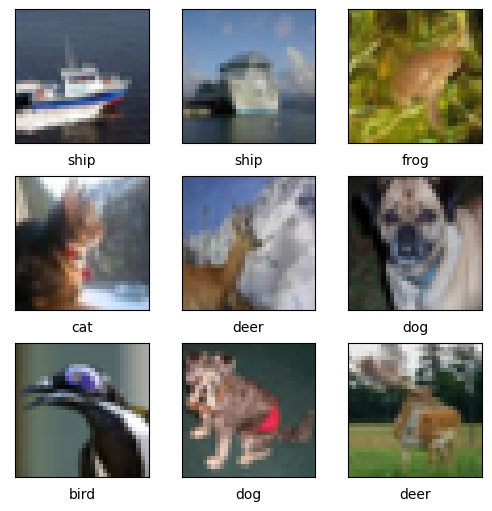

In [164]:
def plot_sample(xb, yb, pred=None):
    fig, axs = plt.subplots(3, 3, figsize=(5, 5), layout='constrained')

    for r in range(3):
        for c in range(3):
            ax = axs[r][c]
            x = xb[r*3 + c]
            y = yb[r*3 + c]
            x = inv_transform(x)
            ax.imshow(x)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_xlabel(ds_train.classes[y])

            if pred != None:
                yh = pred[r*3 + c]
                if yh != y:
                    ax.set_xlabel(ds_train.classes[yh])
                    ax.xaxis.label.set_color('r')

xb, yb = next(iter(dl_train))
plot_sample(xb, yb)

## Model

In [97]:
# y: (B)  yh: (B)
y = torch.tensor([1, 2, 3, 4])
yh = torch.tensor([1, 0, 0, 0])

def accuracy(y, yh):
    return (y == yh).float().mean()

accuracy(y, yh)

tensor(0.2500)

In [111]:
@torch.no_grad()
def eval_split(split, model):
    dl = splits[split]
    num_correct, num_sample = 0, 0

    for xb, yb in dl:
        xb = xb.to(device=device, dtype=dtype)
        yb = yb.to(device=device, dtype=torch.int64)

        logits = model(xb)
        _, idx = logits.max(1)
        num_correct += (yb == idx).sum()
        num_sample += len(yb)

    accuracy = float(num_correct) / num_sample
    return accuracy

eval_split("valid", model)

0.086

## Sanity Check

Check if model has the capacity of overfit a small batch

In [ ]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(32*32*3, 512),
    nn.ReLU(),
    nn.Linear(512, 10)
)

xb, yb = next(iter(dl_train))
y = model(xb)
optimizer = torch.optim.Adam(model.parameters())
xb, yb = next(iter(dl_train))

for i in range(1000):
    optimizer.zero_grad()
    yh = model(xb)
    loss = F.cross_entropy(yh, yb)
    loss.backward()
    optimizer.step()
    
    if i % 100 == 0:
        print(f"{loss.item():.4f}")

Initial loss check

In [ ]:
model = MLP()
dl = torch.utils.data.DataLoader(train_ds, batch_size=512)
xb, yb = next(iter(dl))
yh = model(xb)
loss = F.cross_entropy(yh, yb)
loss.backward()

print("loss:", loss.item())
print("chance:", -torch.tensor(1/10).log().item())

Activation distribution check

In [ ]:
plt.figure(figsize=(20, 4))
legends = []
for i, t in enumerate(model.h):
    print('layer %d: mean %+.2f, std %.2f, saturated: %.2f%%' % (i, t.mean(), t.std(), (t.abs() > 0.99).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i}')

plt.legend(legends);
plt.title('activation distribution');

In [ ]:
plt.figure(figsize=(20, 4))
legends = []
layers = [model.linear1, model.linear2, model.linear3, model.linear4]

for i, l in enumerate(layers):
    t = l.weight.grad
    print('layer %d: mean %+.2f, std %.2f, zero: %.2f%%' % (i, t.mean(), t.std(), (t.abs() < 0.0001).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i}')

plt.legend(legends);
plt.title('gradient distribution');

## Training

In [ ]:
@torch.no_grad()
def grad_ratio(param):
    update = -lr * param.grad 
    return update.std() / param.std()

In [121]:
dl = splits["train"]
lr = 0.005
epoch = 1
i = 0
n = len(dl) * epoch

metrics = []
optimizer = torch.optim.SGD(model.parameters(), lr, weight_decay=0.001)

for _ in range(epoch):
    for xb, yb in dl:
        optimizer.zero_grad()

        logits = model(xb)
        loss = torch.nn.functional.cross_entropy(logits, yb)
        loss.backward()
        
        if i % 10 == 0:
            acc = eval_split("valid", model)
            print(f"{i/n:.2f}: {loss:.4f} {acc:.4f}")
            metrics.append((loss.item(), acc))

            # r = [grad_ratio(p) for p in model.parameters() if p.dim() == 2]
            # update_ratio.append(r)

        i += 1
        optimizer.step()

0.00: 0.9093 0.5130
0.01: 1.3327 0.5320
0.03: 0.8993 0.5180
0.04: 1.0607 0.5160
0.05: 1.1671 0.5260
0.07: 0.9540 0.5270
0.08: 0.9941 0.5290
0.09: 1.0486 0.5260
0.10: 1.0265 0.5420
0.12: 1.2185 0.5310
0.13: 1.3028 0.5260
0.14: 1.0193 0.5330
0.16: 1.0735 0.5330
0.17: 1.0187 0.5390
0.18: 1.1404 0.5220
0.20: 1.1494 0.5390
0.21: 1.2543 0.5240
0.22: 1.0358 0.5390
0.23: 0.8805 0.5370
0.25: 1.2838 0.5380
0.26: 1.1984 0.5280
0.27: 0.8810 0.5280
0.29: 1.0631 0.5290
0.30: 0.9536 0.5300
0.31: 1.0245 0.5300
0.33: 0.9545 0.5240
0.34: 1.0281 0.5410
0.35: 1.2241 0.5340
0.37: 1.1532 0.5200
0.38: 1.0490 0.5250
0.39: 1.1368 0.5040
0.40: 0.9277 0.5220
0.42: 1.0889 0.5240
0.43: 1.1749 0.5330
0.44: 1.2314 0.5280
0.46: 1.0380 0.5300
0.47: 1.2616 0.5320
0.48: 1.0125 0.5200
0.50: 1.0158 0.5230
0.51: 0.8188 0.5210
0.52: 1.1609 0.5240
0.54: 0.9364 0.5300
0.55: 1.0983 0.5310
0.56: 0.9738 0.5240
0.57: 1.1594 0.5260
0.59: 1.2202 0.5220
0.60: 0.9662 0.5250
0.61: 1.1638 0.5280
0.63: 1.1546 0.5240
0.64: 0.9933 0.5100


In [117]:
eval_split("train", model), eval_split("valid", model)

(0.636, 0.513)

Text(0.5, 1.0, 'accuracy')

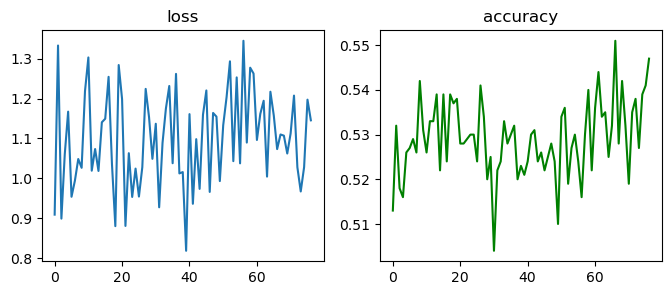

In [138]:
# plot loss and accuracy, one on left and another on the right
tr_loss, va_acc = zip(*metrics)

plt.figure(figsize=(8, 3))

plt.subplot(1, 2, 1)
plt.plot(tr_loss, label="tr_loss")
plt.title("loss")

plt.subplot(1, 2, 2)
plt.plot(va_acc, "g")
plt.title("accuracy")

In [ ]:
# unpack an array update_ratio of tuple into a tuple of array
ur = list(zip(*update_ratio))
for i, r in enumerate(ur):
    plt.plot(np.log10(r), label=f"param {i}")

plt.legend()

In [139]:
@torch.no_grad()
def predict(x):
    logits = model(x)
    prob = F.softmax(logits, dim=1)
    yh = torch.argmax(prob, dim=1)
    return yh

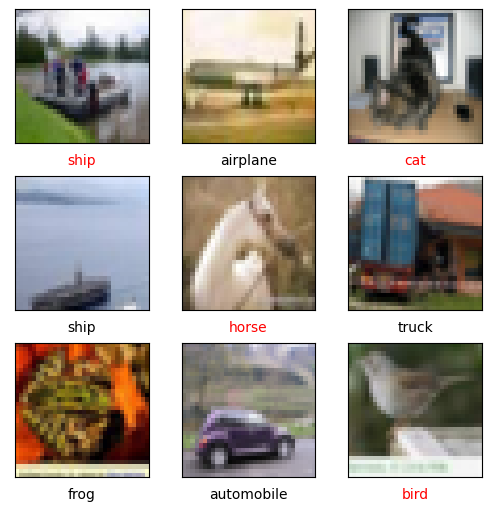

In [166]:
xb, yb = next(iter(dl_valid))
pred = predict(xb)

plot_sample(xb, yb, pred)